In [1]:
from quchem_ibm.Qiskit_Chemistry import *

In [2]:
# transformation='JW'
transformation='BK'

In [3]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
## HAMILTONIAN start

Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'

# Molecule = 'LiH'
# geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.44))]
# basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian_PySCF(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation=transformation)
### HAMILTONIAN end

#####################################

print(QubitHamiltonian)


fci_energy = Hamilt.molecule.fci_energy
print(fci_energy)

(-0.09706626816762878+0j) [] +
(0.045302615503799264+0j) [X0 Z1 X2] +
(0.045302615503799264+0j) [X0 Z1 X2 Z3] +
(0.045302615503799264+0j) [Y0 Z1 Y2] +
(0.045302615503799264+0j) [Y0 Z1 Y2 Z3] +
(0.1714128264477689+0j) [Z0] +
(0.17141282644776892+0j) [Z0 Z1] +
(0.1659278503377034+0j) [Z0 Z1 Z2] +
(0.1659278503377034+0j) [Z0 Z1 Z2 Z3] +
(0.12062523483390414+0j) [Z0 Z2] +
(0.12062523483390414+0j) [Z0 Z2 Z3] +
(0.16868898170361207+0j) [Z1] +
(-0.22343153690813558+0j) [Z1 Z2 Z3] +
(0.1744128761226159+0j) [Z1 Z3] +
(-0.22343153690813564+0j) [Z2]
-1.137283834488502


From Helgaker, T., P. Jorgensen,and J. Olsen (2014),Molecularelectronic-structure theory(John Wiley & Sons)
we known

$$H_{2}^{ground} = 0.9939| 1100\rangle - 0.1106| 0011\rangle$$

From group theory we know only double excitation terms are important!
We can see this from our ijab operators that qubits 1 and 3 are only acted on by $Z$ therefore experience no population changes... Can even see this from the answer if we write it in BK basis:

$$H_{2}^{BK} = 0.9939| 1000\rangle - 0.1106| 0010\rangle$$

See how qubits 1 and 3 always remain at 0!

therefore can **remove** these measurements from Hamiltonian... as we know what expectation values they should give!

In the case for this Hamiltonian only $I$ and $Z$ act on these qubits! So even easier to remove (expectation values = +1 (as act on $| 0\rangle$ state!), so just remove and add to relivent H terms!

LOOK at:

PHYS. REV. X, **8**, 031022 (2018)

In [48]:
from quchem.Ansatz_Generator_Functions import *
n_electrons=Hamilt.molecule.n_electrons
n_qubits=Hamilt.molecule.n_qubits

ansatz_obj = Ansatz(n_electrons,n_qubits)
print('JW ground state = ', ansatz_obj.Get_JW_HF_state_in_OCC_basis())
print('BK ground state = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())

JW ground state =  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
BK ground state =  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
qubits_to_remove = Find_I_Z_indices_in_Hamiltonian(QubitHamiltonian, Hamilt.molecule.n_qubits)
print('qubits only acted on by I or Z:', qubits_to_remove)


input_state = ansatz_obj.Get_BK_HF_state_in_OCC_basis() if transformation=='BK' else ansatz_obj.Get_JW_HF_state_in_OCC_basis()
# Remove_Z_terms_from_Hamiltonian
NewQubitHamiltonian = Remove_Z_terms_from_Hamiltonian(
                                                    QubitHamiltonian, 
                                                    input_state,
                                                    qubits_to_remove,
                                                    check_reduction=True)
NewQubitHamiltonian

qubits only acted on by I or Z: [1 3]


(0.2460355896585992+0j) [] +
(0.09060523100759853+0j) [X0 X2] +
(0.09060523100759853+0j) [Y0 Y2] +
(0.3428256528955378+0j) [Z0] +
(0.5731061703432151+0j) [Z0 Z2] +
(-0.4468630738162712+0j) [Z2]

In [50]:
qubitNo_re_label_dict, NewQubitHamiltonian_relabelled = Re_label_Hamiltonian(NewQubitHamiltonian)
NewQubitHamiltonian_relabelled

(-7.260619741492415+0j) [] +
(0.011497423441268764+0j) [X0 X1 X2 X3] +
(-0.0010392748539536148+0j) [X0 X1 Y2 Y3 Z4 Z5] +
(0.00479729705856226+0j) [X0 X1 Z2 Y3 Y4 Z5] +
(-0.001340913567482682+0j) [X0 Y1 X2 Y3] +
(0.010119437379027815+0j) [X0 Y1 Y2 X3] +
(0.003758022204608646+0j) [X0 Y1 Y2 X3 Z4] +
(-0.00479729705856226+0j) [X0 Y1 Y3 X4] +
(0.002913674012761853+0j) [X0 Z1 X2] +
(0.0060847086035769665+0j) [X0 Z1 Z3 X4 Z5] +
(0.0060847086035769665+0j) [X0 Z1 X4] +
(0.002913674012761853+0j) [X0 X2 Z3] +
(0.0010392748539536148+0j) [Y0 X1 X2 Y3 Z4 Z5] +
(0.011497423441268764+0j) [Y0 X1 Y2 X3] +
(-0.00479729705856226+0j) [Y0 X1 Z2 Y3 X4 Z5] +
(-0.010119437379027815+0j) [Y0 Y1 X2 X3] +
(-0.003758022204608646+0j) [Y0 Y1 X2 X3 Z4] +
(-0.001340913567482682+0j) [Y0 Y1 Y2 Y3] +
(-0.00479729705856226+0j) [Y0 Y1 Y3 Y4] +
(0.002913674012761853+0j) [Y0 Z1 Y2] +
(0.0060847086035769665+0j) [Y0 Z1 Z3 Y4 Z5] +
(0.0060847086035769665+0j) [Y0 Z1 Y4] +
(0.002913674012761853+0j) [Y0 Y2 Z3] +
(0.0293686577030514

# Find what new FCI energy is
- here should be the same as true answer!

In [51]:
from openfermion import qubit_operator_sparse
from scipy.sparse import csc_matrix
new_Molecular_H_MATRIX =  csc_matrix(qubit_operator_sparse(NewQubitHamiltonian_relabelled))

# new_Molecular_H_MATRIX = np.flip(new_Molecular_H_MATRIX)

from scipy.sparse.linalg import eigs
try:
    eig_values, eig_vectors = eigs(new_Molecular_H_MATRIX)
except:
    from scipy.linalg import eig
    eig_values, eig_vectors = eig(new_Molecular_H_MATRIX.todense())
    
new_FCI_Energy = min(eig_values)


index = np.where(eig_values==new_FCI_Energy)[0][0]
ground_state_vector = eig_vectors[:, index]

print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', fci_energy)
print(np.isclose(new_FCI_Energy, fci_energy))

new_FCI =  (-7.863320217575005+6.379586053847133e-16j) VS old FCI: -7.880574281802676
False


In [52]:
np.dot(ground_state_vector.conj().T, new_Molecular_H_MATRIX.dot(ground_state_vector))

(-7.86332021757501+4.440892098500626e-16j)

# HF + UCCSD

In [56]:
input_state = ansatz_obj.Get_BK_HF_state_in_OCC_basis() if transformation=='BK' else ansatz_obj.Get_JW_HF_state_in_OCC_basis()
new_input_state = np.delete(input_state, qubits_to_remove)

n_qubits_new = len(new_input_state)
new_input_state

array([1., 0., 0., 0., 0., 0.])

In [53]:
ansatz_obj.Get_ia_and_ijab_terms()

print('ia standard')
print(ansatz_obj.Sec_Quant_CC_ia_Fermi_ops)

print('ijab standard')
print(ansatz_obj.Sec_Quant_CC_ijab_Fermi_ops)

### single trotter step
ansatz_obj.UCCSD_single_trotter_step(transformation,
                                     List_FermiOps_ia=ansatz_obj.Sec_Quant_CC_ia_Fermi_ops,
                                     List_FermiOps_ijab=ansatz_obj.Sec_Quant_CC_ijab_Fermi_ops)

print('')
print('ia standard')
print(ansatz_obj.Second_Quant_CC_single_Trot_list_ia)
print('ijab standard')
print(ansatz_obj.Second_Quant_CC_single_Trot_list_ijab)

ia standard
[-1.0 [0^ 4] +
1.0 [4^ 0], -1.0 [0^ 6] +
1.0 [6^ 0], -1.0 [0^ 8] +
1.0 [8^ 0], -1.0 [0^ 10] +
1.0 [10^ 0], -1.0 [2^ 4] +
1.0 [4^ 2], -1.0 [2^ 6] +
1.0 [6^ 2], -1.0 [2^ 8] +
1.0 [8^ 2], -1.0 [2^ 10] +
1.0 [10^ 2], -1.0 [1^ 5] +
1.0 [5^ 1], -1.0 [1^ 7] +
1.0 [7^ 1], -1.0 [1^ 9] +
1.0 [9^ 1], -1.0 [1^ 11] +
1.0 [11^ 1], -1.0 [3^ 5] +
1.0 [5^ 3], -1.0 [3^ 7] +
1.0 [7^ 3], -1.0 [3^ 9] +
1.0 [9^ 3], -1.0 [3^ 11] +
1.0 [11^ 3]]
ijab standard
[-1.0 [0^ 2^ 4 6] +
1.0 [6^ 4^ 2 0], -1.0 [0^ 2^ 4 8] +
1.0 [8^ 4^ 2 0], -1.0 [0^ 2^ 4 10] +
1.0 [10^ 4^ 2 0], -1.0 [0^ 2^ 6 8] +
1.0 [8^ 6^ 2 0], -1.0 [0^ 2^ 6 10] +
1.0 [10^ 6^ 2 0], -1.0 [0^ 2^ 8 10] +
1.0 [10^ 8^ 2 0], -1.0 [1^ 3^ 5 7] +
1.0 [7^ 5^ 3 1], -1.0 [1^ 3^ 5 9] +
1.0 [9^ 5^ 3 1], -1.0 [1^ 3^ 5 11] +
1.0 [11^ 5^ 3 1], -1.0 [1^ 3^ 7 9] +
1.0 [9^ 7^ 3 1], -1.0 [1^ 3^ 7 11] +
1.0 [11^ 7^ 3 1], -1.0 [1^ 3^ 9 11] +
1.0 [11^ 9^ 3 1], -1.0 [0^ 1^ 4 5] +
1.0 [5^ 4^ 1 0], -1.0 [0^ 1^ 4 7] +
1.0 [7^ 4^ 1 0], -1.0 [0^ 1^ 4 9] +
1.0 [9^ 4^ 1 

In [54]:
new_CC_ia_single_trot = Remove_indices_from_qubit_ops(ansatz_obj.Second_Quant_CC_single_Trot_list_ia,
                                                      qubits_to_remove)
print('ia reduced')
print(new_CC_ia_single_trot)

new_CC_ijab_single_trot = Remove_indices_from_qubit_ops(ansatz_obj.Second_Quant_CC_single_Trot_list_ijab,
                                                      qubits_to_remove)
print('ijab reduced')
print(new_CC_ijab_single_trot)


relabelled_new_CC_ia_single_trot =Re_label_qubit_operators(qubitNo_re_label_dict, new_CC_ia_single_trot)
relabelled_new_CC_ijab_single_trot =Re_label_qubit_operators(qubitNo_re_label_dict, new_CC_ijab_single_trot)

print('')
print('ia reduced relabelled')
print(relabelled_new_CC_ia_single_trot)
print('')
print('ijab reduced relabelled')
print(relabelled_new_CC_ijab_single_trot)

ia reduced
[0.5j [Y3 X4] +
0.5j [Y3 Y4], 0.5j [Y3 Z5 X6] +
0.5j [Y3 Z5 Y6], 1j [X3 Y7], 1j [X3 Y7], 0.5j [X2 Y3 X4] +
0.5j [Y2 Y3 Y4], 0.5j [X2 Y3 Z5 X6] +
0.5j [Y2 Y3 Z5 Y6], 0.5j [X2 X3 Y7] +
0.5j [Y2 X3 Y7], 0.5j [X2 X3 Y7] +
0.5j [Y2 X3 Y7], 0.5j [Y3 Z4 X5] +
0.5j [Y3 Y5], -0.5j [X3 Z7] +
0.5j [Y3 Z5 Z6], 1j [X3 Y7], 1j [X3 Y7], 0.5j [Z2 Y3 Z4 X5] +
-0.5j [X3 Y5], 0.5j [Z2 Y3 Z5 Z6] +
-0.5j [Y3 Z7], 0.5j [Z2 X3 Y7] +
0.5j [Y3 Y7], 0.5j [Z2 X3 Y7] +
0.5j [Y3 Y7]]
ijab reduced
[-0.125j [X2 X4 Y5 X6] +
0.125j [X2 X4 Y5 Y6] +
0.125j [X2 Y4 Y5 X6] +
0.125j [X2 Y4 Y5 Y6] +
-0.125j [Y2 X4 Y5 X6] +
-0.125j [Y2 X4 Y5 Y6] +
-0.125j [Y2 Y4 Y5 X6] +
0.125j [Y2 Y4 Y5 Y6], 0.25j [X2 Z3 Y4 X5 Y7] +
-0.25j [Y2 Z3 X4 X5 Y7], 0.25j [X2 Z3 Y4 X5 Y7] +
-0.25j [Y2 Z3 X4 X5 Y7], 0.25j [X2 Z3 Z5 Y6 Y7] +
-0.25j [Y2 Z3 Z5 X6 Y7], 0.25j [X2 Z3 Z5 Y6 Y7] +
-0.25j [Y2 Z3 Z5 X6 Y7], 0.25j [X2] +
-0.25j [Y2], -0.125j [Z2 Z3 Z4 X5 Z7] +
0.125j [Z2 Z3 Y5 Z7] +
0.125j [Z2 Z4 Y5 Z6] +
-0.125j [Z2 X5 Z6] +
0.125j [

# Ansatz Circuit

In [12]:
# for op in relabelled_new_CC_ia_single_trot[1]:
#     print(op)
# print(list(op.terms.keys())[0])

In [13]:
# UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(new_input_state,
#                                      relabelled_new_CC_ia_single_trot, 
#                                      relabelled_new_CC_ijab_single_trot)

# theta_ia = [0 for _ in range(len(relabelled_new_CC_ia_single_trot))]
# theta_ijab = [0 for _ in range(len(relabelled_new_CC_ijab_single_trot))]

# UCCSD_ansatz_Q_Circ =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
#                                         Theta_param_list_ia=theta_ia, 
#                                          Theta_param_list_ijab=theta_ijab,
#                                          ia_first=True)
# UCCSD_ansatz_Q_Circ

In [57]:
n_qubits= len(new_input_state)
check_ansatz_state = False

standard_VQE_circuits, standard_I_term = Build_Standard_VQE_circuits(NewQubitHamiltonian_relabelled, 
                                                    ground_state_vector,
                                                    n_qubits, 
                                                    check_ansatz_state=check_ansatz_state)

Getting_standard_VQE_circuits: 62it [00:01, 34.99it/s]


In [58]:
# lin alg approach!
standard_VQE_lin_alg(NewQubitHamiltonian_relabelled,
                     ground_state_vector,
                     n_qubits,
                     check_ansatz_state=check_ansatz_state)

performing_standard_VQE: 62it [00:00, 696.69it/s]


(-7.8633202175749535+0j)

# Graph

In [59]:
from tqdm.notebook import tqdm

In [60]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(NewQubitHamiltonian_relabelled)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)

anti_commuting_sets

Building Graph Edges: 100%|##########| 62/62 [00:00<00:00, 353.32it/s]


{0: [(-7.260619741492415+0j) []],
 1: [(0.0782363777898522+0j) [Z1 Z3 Z5]],
 2: [(0.054233679379878136+0j) [Z0 Z1 Z2 Z3],
  (0.010339540828500133+0j) [Z1 X2 Z3 X4 Z5],
  (-0.00479729705856226+0j) [Y0 Y1 Y3 Y4],
  (0.0060847086035769665+0j) [Y0 Z1 Y4],
  (0.004797297058562261+0j) [Z0 X1 Y2 Y3 X4 Z5]],
 3: [(-0.15781721223902007+0j) [Z1 Z3 Z4 Z5],
  (0.010339540828500133+0j) [Y2 Z3 Y4],
  (0.0060847086035769665+0j) [X0 Z1 Z3 X4 Z5],
  (-0.00479729705856226+0j) [Y0 X1 Z2 Y3 X4 Z5],
  (-0.004797297058562261+0j) [X1 Y2 X3 Y4]],
 4: [(-0.15781721223902007+0j) [Z4],
  (0.00479729705856226+0j) [X0 X1 Z2 Y3 Y4 Z5],
  (0.0060847086035769665+0j) [Y0 Z1 Z3 Y4 Z5],
  (-0.004797297058562261+0j) [X1 X2 X3 X4],
  (0.010339540828500133+0j) [X2 Z3 X4]],
 5: [(0.054233679379878136+0j) [Z0 Z2],
  (-0.004797297058562261+0j) [Z0 X1 X2 Y3 Y4 Z5],
  (0.0060847086035769665+0j) [X0 Z1 X4],
  (-0.00479729705856226+0j) [X0 Y1 Y3 X4],
  (0.010339540828500133+0j) [Z1 Y2 Z3 Y4 Z5]],
 6: [(-0.003758022204608646+0j) [

# Seq Rot circuits

In [62]:
n_qubits= len(new_input_state)
S_index=0

q_reg = QuantumRegister(n_qubits)
qcirc = QuantumCircuit(q_reg)

Build_reduction_circuit_seq_rot_IBM(anti_commuting_sets[2], S_index, q_reg, n_qubits, check_reduction=True)

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546d0bb510>,
 1 [Z0 Z1 Z2 Z3],
 (0.05595757214667434+0j))

In [63]:
n_qubits= len(new_input_state)
check_ansatz_state = False
rotation_reduction_check=True

Seq_Rot_VQE_circuits, Seq_Rot_I_term = Get_Seq_Rot_Unitary_Part_circuits(
                                anti_commuting_sets, 
                                ground_state_vector, 
                                n_qubits,
                                S_index_dict=None, 
                                rotation_reduction_check=rotation_reduction_check,
                                check_ansatz_state=check_ansatz_state)

Getting seq_rot VQE circuits: 100%|##########| 26/26 [00:01<00:00, 25.14it/s]


In [64]:
Seq_Rot_VQE_circuits

[{'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546d16ff90>,
  'coeff': (0.0782363777898522+0j),
  'qubitOp': (0.0782363777898522+0j) [Z1 Z3 Z5]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f54b67ca1d0>,
  'gamma_l': (0.05595757214667434+0j),
  'Ps': 1 [Z0 Z1 Z2 Z3]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546d14fe90>,
  'gamma_l': (0.15841789791676555+0j),
  'Ps': 1 [Z1 Z3 Z4 Z5]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546c267e90>,
  'gamma_l': (0.15841789791676555+0j),
  'Ps': 1 [Z4]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546c1e6ad0>,
  'gamma_l': (0.05595757214667434+0j),
  'Ps': 1 [Z0 Z2]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f546c061290>,
  'gamma_l': (0.1439731799687819+0j),
  'Ps': 1 [Y1 Z2 Y3 Z4 Z5]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f54b5780190>,
  'gamma_l': (0.144279440088673+0j),
  'Ps': 1 [Z

In [65]:
#lin alg approach

n_qubits= len(new_input_state)
check_ansatz_state = False
rotation_reduction_check=True

Seq_Rot_VQE_lin_alg(anti_commuting_sets,
                    ground_state_vector,
                    n_qubits,
                    S_index_dict=None,
                    rotation_reduction_check=rotation_reduction_check,
                     check_ansatz_state=check_ansatz_state)

Performing seq_rot VQE lin alg: 100%|##########| 26/26 [00:00<00:00, 68.36it/s]


(-7.863320217574951+0j)

# LCU circuits

In [66]:
n_qubits= len(new_input_state)
check_ansatz_state = False

LCU_VQE_circuits, LCU_I_term= Get_LCU_Unitary_Part_circuits(anti_commuting_sets, ground_state_vector, n_qubits, 
                                  N_index_dict=None,check_ansatz_state=check_ansatz_state)

Getting LCU VQE circuits: 100%|##########| 26/26 [00:04<00:00,  5.31it/s]


In [23]:
LCU_VQE_circuits

[{'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f54dc318cd0>,
  'coeff': (0.5731061703432151+0j),
  'qubitOp': (0.5731061703432151+0j) [Z0 Z1]},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f54dc328690>,
  'gamma_l': (0.35459658228639496+0j),
  'Pn': 1 [Z0],
  'N_ancilla': 1},
 {'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f54dc342dd0>,
  'gamma_l': (0.455956044621043+0j),
  'Pn': 1 [Z1],
  'N_ancilla': 1}]

In [67]:
#lin alg approach
n_qubits= len(new_input_state)
check_ansatz_state = False

LCU_VQE_lin_alg(anti_commuting_sets,
                ground_state_vector,
                n_qubits,
                N_index_dict=None,
             check_ansatz_state=check_ansatz_state)

Performing LCU VQE lin alg: 100%|##########| 26/26 [00:11<00:00,  2.25it/s]


(-7.86332021757495-1.2736685087049714e-17j)

# Run circuits!

In [68]:
from qiskit.compiler import transpile, assemble

In [69]:
def Run_exp(list_of_circuit_dicts, backend, n_shots, method_name, optimization_level=None):
    
    qc_list = [exp_dict['circuit'] for exp_dict in list_of_circuit_dicts if exp_dict['circuit']]
    
    transpiled_circs = transpile(qc_list, backend=backend, optimization_level=optimization_level)
    
    if method_name == 'LCU':
        qobjs = assemble(transpiled_circs, backend=backend, shots=n_shots, memory=True) #memory = True!
    else:
        qobjs = assemble(transpiled_circs, backend=backend, shots=n_shots)
        
    
    job = backend.run(qobjs)
    

    if method_name == 'LCU':
        results = [job.result().get_memory(circuit) for circuit in transpiled_circs]
    else:
        results = [job.result().get_counts(circuit) for circuit in transpiled_circs]
    
    return results

In [70]:
backend = Aer.get_backend('qasm_simulator')
method_name = 'seq_rot'
n_shots=8192

seq_rot_results = Run_exp(Seq_Rot_VQE_circuits, backend, n_shots, method_name)
# seq_rot_results

In [71]:
backend = Aer.get_backend('qasm_simulator')
method_name = 'LCU'
n_shots=8192

LCU_results = Run_exp(LCU_VQE_circuits, backend, n_shots, method_name)
# LCU_results

In [72]:
backend = Aer.get_backend('qasm_simulator')
method_name = 'standard'
n_shots=8192

standard_results = Run_exp(standard_VQE_circuits, backend, n_shots, method_name)
standard_results

[{'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1},
 {'000001': 8177, '010000': 13, '000100': 1, '001110': 1

In [30]:
# qc_list = [exp_dict['circuit'] for exp_dict in standard_VQE_circuits if exp_dict['circuit']]
    
# transpiled_circs = transpile(qc_list, backend=backend, optimization_level=None)
    
# for circuit in transpiled_circs:
#     print(circuit.draw())
    
# for circuit in qc_list:
#     print(circuit.draw())

In [31]:
ancilla_list = [exp_dict['N_ancilla'] for exp_dict in LCU_VQE_circuits if 'N_ancilla' in exp_dict.keys()]
ancilla_list

[1, 1]

## Exp!

In [73]:
from quchem_ibm.IBM_experiment_functions import *

In [74]:
my_provider = load_IBM_provider()

/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-17 09:35:50,858: Credentials are already in use. The existing account in the session will be replaced.


In [75]:
n_shots=8192
n_system= len(new_input_state)


# method_name = 'standard'
# qc_circuit_dictionary_list = standard_VQE_circuits
# I_term= standard_I_term

# method_name = 'seq_rot'
# qc_circuit_dictionary_list = Seq_Rot_VQE_circuits
# I_term=Seq_Rot_I_term

method_name = 'LCU'
qc_circuit_dictionary_list = LCU_VQE_circuits
I_term=LCU_I_term  

experiment = run_VQE_unitary_part_experiments(
    method_name,
    qc_circuit_dictionary_list,
    my_provider,
    n_shots,
    n_system,
    I_term,
    save=False, 
    optimization_level=3,
    backend_name=None)

## running job ## 

## job finished ## 



In [35]:
# import pickle
# import os

In [36]:
# base_dir = os.getcwd()
# data_dir = os.path.join(base_dir, 'Data_loop_label=2020Aug28-131222977352')

# all_results=[]
# for dirpath, dirnames, filenames in os.walk(data_dir):
#     for filename in filenames:
#         if filename.endswith('.pickle'):
#             filepath = os.path.join(data_dir, filename)
#             with open(filepath, 'rb') as handle:
#                 all_results.append(pickle.load(handle))

In [37]:
def exp_analysis(experiment_output_dict):
    
    if experiment_output_dict['method'] == 'LCU':
        E_sim=[experiment_output_dict['I_term']]
        for index, exp_dict_input in enumerate(experiment_output_dict['experiment_dict']):
            
            if 'Pn' in exp_dict_input.keys():
                list_of_measurements = experiment['SIM_memory_raw'][index]
                N_ancilla = exp_dict_input['N_ancilla']
                sim_post_selct_counts = Get_post_selection_counts_LCU(list_of_measurements, N_ancilla)
            else:
                list_of_measurements = experiment['SIM_memory_raw'][index]
                N_ancilla=0
                sim_post_selct_counts = Get_post_selection_counts_LCU(list_of_measurements, N_ancilla)
            
            measured_P= exp_dict_input['Pn'] if 'Pn' in exp_dict_input.keys() else exp_dict_input['qubitOp']
            coeff = exp_dict_input['coeff'] if 'coeff' in exp_dict_input.keys() else exp_dict_input['gamma_l']
            
            exp_val = calc_exp_pauliword(sim_post_selct_counts, measured_P)
            
            E_sim.append(exp_val*coeff)
        
        return sum(E_sim)
    
    elif experiment_output_dict['method'] == 'seq_rot':
        
        E_sim=[experiment_output_dict['I_term']]
        for index, exp_dict_input in enumerate(experiment_output_dict['experiment_dict']):
            sim_count_dict = experiment_output_dict['SIM_count_list_raw'][index]
            measured_P= exp_dict_input['Ps'] if 'Ps' in exp_dict_input.keys() else exp_dict_input['qubitOp']
            coeff = exp_dict_input['coeff'] if 'coeff' in exp_dict_input.keys() else exp_dict_input['gamma_l']
            exp_val = calc_exp_pauliword(sim_count_dict, measured_P)
            
            E_sim.append(exp_val*coeff)
        
        return sum(E_sim)
        
        
    elif experiment_output_dict['method'] == 'standard':
        
        E_sim=[experiment_output_dict['I_term']]
        for index, exp_dict_input in enumerate(experiment_output_dict['experiment_dict']):
            sim_count_dict = experiment_output_dict['SIM_count_list_raw'][index]
            measured_P= exp_dict_input['qubitOp']
            coeff = exp_dict_input['coeff'] 
            exp_val = calc_exp_pauliword(sim_count_dict, measured_P)
            
            E_sim.append(exp_val*coeff)
        
        return sum(E_sim)
    else:
        raise ValueError('unknown VQE method {}'.format(experiment_output_dict['method']))
        
    

In [76]:
exp_analysis(experiment)

(-7.862947979552186+0j)

In [77]:
experiment['q_circuit_list'][2].draw()

┌──────────────────┐                          ┌───┐        ┌───┐»
q1011_0: ┤5                 ├──────────────────────────┤ X ├────────┤ Y ├»
         │                  │┌───────────┐             └─┬─┘        └─┬─┘»
q1011_1: ┤4                 ├┤ (-0-1j)*Z ├───────────────┼────────────┼──»
         │                  │└─────┬─────┘┌───┐          │            │  »
q1011_2: ┤3                 ├──────┼──────┤ Y ├──────────┼────────────┼──»
         │  disentangler_dg │      │      └─┬─┘          │            │  »
q1011_3: ┤2                 ├──────┼────────┼────────────┼────────────┼──»
         │                  │      │        │  ┌───┐     │  ┌──────┐  │  »
q1011_4: ┤1                 ├──────┼────────┼──┤ X ├─────┼──┤ 1j*Y ├──┼──»
         │                  │      │        │  └─┬─┘     │  └──┬───┘  │  »
q1011_5: ┤0                 ├──────┼────────┼────┼───■───┼─────┼──────┼──»
         ├──────────────────┤      │        │    │   │   │     │      │  »
q1521_0: ┤0                 ├──────■────────■────■───■───o─────o──────■──»
         │                  │      │        │    │   │   │     │      │  »
q1521_1: ┤1 disentangler_dg ├──────o────────o────o───o───■─────■──────■──»
         │                  │      │        │    │   │   │     │      │  »
q1521_2: ┤2                 ├──────o────────o────o───o───o─────o──────o──»
         └──────────────────┘                                            »
 meas: 9/════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                  »
«q1011_0: ─────────────────────────────────────────────────────────»
«         ┌───────────┐             ┌───────────┐                  »
«q1011_1: ┤ (-0-1j)*Y ├─────────────┤ (-0-1j)*Y ├──────────────────»
«         └─────┬─────┘             └─────┬─────┘┌───┐             »
«q1011_2: ──────┼───────■─────────────────┼──────┤ Y ├─────────────»
«               │       │ ┌───┐           │      └─┬─┘┌───┐        »
«q1011_3: ──────┼───────┼─┤ X ├───────────┼────────┼──┤ Y ├────────»
«               │       │ └─┬─┘┌───┐      │        │  └─┬─┘┌───┐   »
«q1011_4: ──────┼───────┼───┼──┤ Y ├──────┼────────┼────┼──┤ X ├───»
«               │       │   │  └─┬─┘      │        │    │  └─┬─┘   »
«q1011_5: ──────┼───────┼───┼────┼────────┼────────┼────┼────┼───■─»
«               │       │   │    │        │        │    │    │   │ »
«q1521_0: ──────■───────■───■────■────────o────────o────o────o───o─»
«               │       │   │    │        │        │    │    │   │ »
«q1521_1: ──────■───────■───■────■────────o────────o────o────o───o─»
«               │       │   │    │        │        │    │    │   │ »
«q1521_2: ──────o───────o───o────o────────■────────■────■────■───■─»
«                                                                  »
« meas: 9/═════════════════════════════════════════════════════════»
«                                                                  »
«                                 ░ ┌─┐                        
«q1011_0: ────────────────────────░─┤M├────────────────────────
«                                 ░ └╥┘┌─┐                     
«q1011_1: ────────────────────────░──╫─┤M├─────────────────────
«                                 ░  ║ └╥┘┌─┐                  
«q1011_2: ────────────────────────░──╫──╫─┤M├──────────────────
«                                 ░  ║  ║ └╥┘┌─┐               
«q1011_3: ────────────────────────░──╫──╫──╫─┤M├───────────────
«                                 ░  ║  ║  ║ └╥┘┌─┐            
«q1011_4: ────────────────────────░──╫──╫──╫──╫─┤M├────────────
«                                 ░  ║  ║  ║  ║ └╥┘┌─┐         
«q1011_5: ────────────────────────░──╫──╫──╫──╫──╫─┤M├─────────
«         ┌─────────────────────┐ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
«q1521_0: ┤0                    ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
«         │                     │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
«q1521_1: ┤1 disentangler

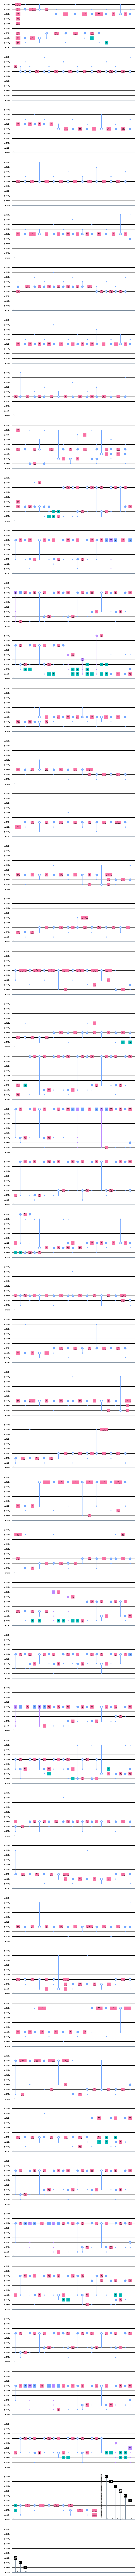

In [78]:
# experiment['SIM_transpiled_q_circuit_list'][2].draw()
experiment['SIM_transpiled_q_circuit_list'][2].draw(output='mpl')

In [ ]:
n_qubits= len(new_input_state)
check_ansatz_state = False

standard_VQE_circuits, standard_I_term = Build_Standard_VQE_circuits(NewQubitHamiltonian_relabelled, 
                                                    ground_state_vector,
                                                    n_qubits, 
                                                    check_ansatz_state=check_ansatz_state)